In [2]:
import os
import gc

os.chdir('../../')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from global_code.util import reduce_mem_usage
import matplotlib.pyplot as plt
import seaborn as sns
from global_code.util import reduce_mem_usage, clf_metric_report, compute_and_plot_permutation_importance, plot_pr_calib_curve, plot_dis_probs, plot_shap_values
import optuna
import arfs.feature_selection.allrelevant as arfsgroot
import shap
import json
import joblib
from venn_abers import VennAbersCalibrator

sns.set(style='whitegrid')

/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read train, validation and calibration data

In [4]:
train_df = pd.read_parquet('./week_1/data/processed/train_df.parquet')
validation_df = pd.read_parquet('./week_1/data/processed/validation_df.parquet')
calibration_df = pd.read_parquet('./week_1/data/processed/calibration_df.parquet')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306649 entries, 1157596 to 4750783
Columns: 153 entries, interest_rate to churn_420
dtypes: bool(1), category(2), float16(92), float32(37), int16(5), int32(2), int8(14)
memory usage: 109.7 MB


In [6]:
cat_features = ['country', 'broad_job_category']
train_df[cat_features].dtypes

country               category
broad_job_category    category
dtype: object

### Train, Validation, Test Split

In [7]:
target = 'churn_420'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_validation.shape, y_validation.shape)

Train Shape:  (306649, 152) (306649,)
Validation shape:  (70878, 152) (70878,)
Calibration shape:  (70878, 152) (70878,)


In [8]:
print('Train Churn Values count:\n', y_train.value_counts())
print(y_train.value_counts(normalize=True))

Train Churn Values count:
 churn_420
0    304795
1      1854
Name: count, dtype: int64
churn_420
0    0.993954
1    0.006046
Name: proportion, dtype: float64


In [9]:
print('Validation Churn Values count:\n', y_validation.value_counts())
print(y_validation.value_counts(normalize=True))

Validation Churn Values count:
 churn_420
0    69890
1      988
Name: count, dtype: int64
churn_420
0    0.986061
1    0.013939
Name: proportion, dtype: float64


In [10]:
print('Calibration Churn Values count:\n', y_calibration.value_counts())
print(y_calibration.value_counts(normalize=True))

Calibration Churn Values count:
 churn_420
0    279559
1      3951
Name: count, dtype: int64
churn_420
0    0.986064
1    0.013936
Name: proportion, dtype: float64


### Train a Vanilla Baseline CatBoost Model

In [11]:
# Using PRAUC Use Weights False to not inflat the PRAUC metric
model = CatBoostClassifier(iterations=1000, auto_class_weights='Balanced', eval_metric='PRAUC:use_weights=false', cat_features=cat_features, verbose=True, random_seed=55) 

print('Traning the model...')
model.fit(X_train, y_train, eval_set=(X_validation, y_validation), early_stopping_rounds=100)

print('Evaluating the model...')
y_pred = model.predict_proba(X_validation)[:, 1]

Traning the model...
Learning rate set to 0.13035
0:	learn: 0.0181174	test: 0.0268806	best: 0.0268806 (0)	total: 169ms	remaining: 2m 48s
1:	learn: 0.0179030	test: 0.0232292	best: 0.0268806 (0)	total: 244ms	remaining: 2m 1s
2:	learn: 0.0151649	test: 0.0231668	best: 0.0268806 (0)	total: 323ms	remaining: 1m 47s
3:	learn: 0.0159796	test: 0.0245276	best: 0.0268806 (0)	total: 428ms	remaining: 1m 46s
4:	learn: 0.0172575	test: 0.0264188	best: 0.0268806 (0)	total: 515ms	remaining: 1m 42s
5:	learn: 0.0174242	test: 0.0263375	best: 0.0268806 (0)	total: 606ms	remaining: 1m 40s
6:	learn: 0.0175413	test: 0.0262474	best: 0.0268806 (0)	total: 702ms	remaining: 1m 39s
7:	learn: 0.0176111	test: 0.0260245	best: 0.0268806 (0)	total: 792ms	remaining: 1m 38s
8:	learn: 0.0177879	test: 0.0260034	best: 0.0268806 (0)	total: 878ms	remaining: 1m 36s
9:	learn: 0.0178982	test: 0.0264231	best: 0.0268806 (0)	total: 975ms	remaining: 1m 36s
10:	learn: 0.0182097	test: 0.0269570	best: 0.0269570 (10)	total: 1.1s	remaining: 

In [12]:
# Metrics Report
clf_metric_report(y_pred, y_validation)

Evaluating the model...
ROC AUC: 0.6879001588963107
Brier Score: 0.29533911260848816
Average Precision: 0.029629163063940703
Log Loss: 0.7800804375344214


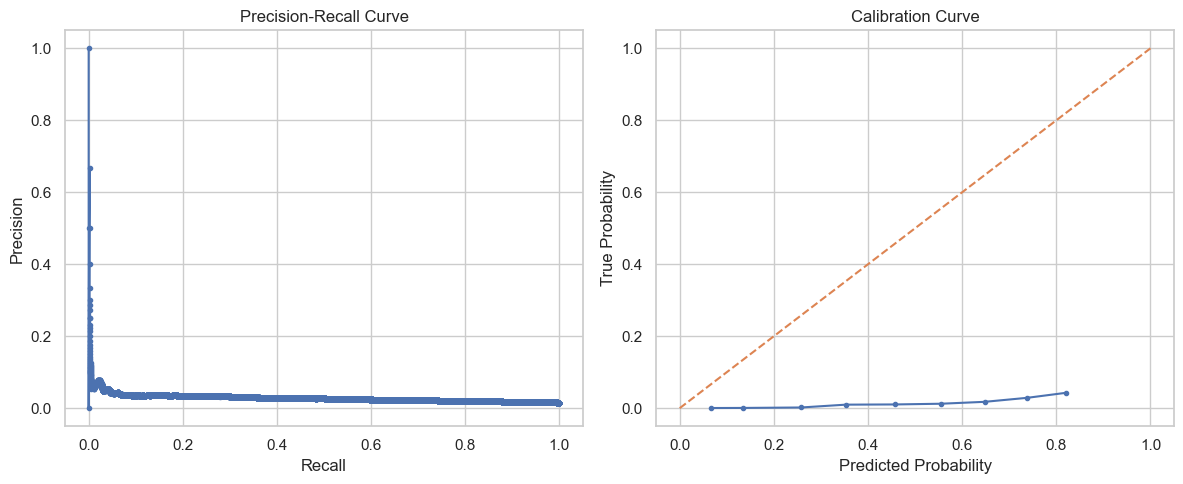

In [13]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred, y_validation)

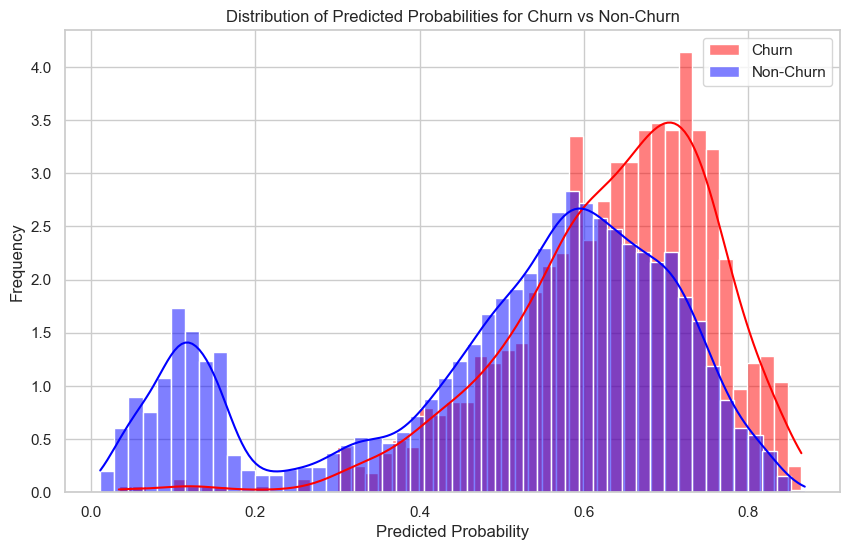

In [14]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred, y_validation)

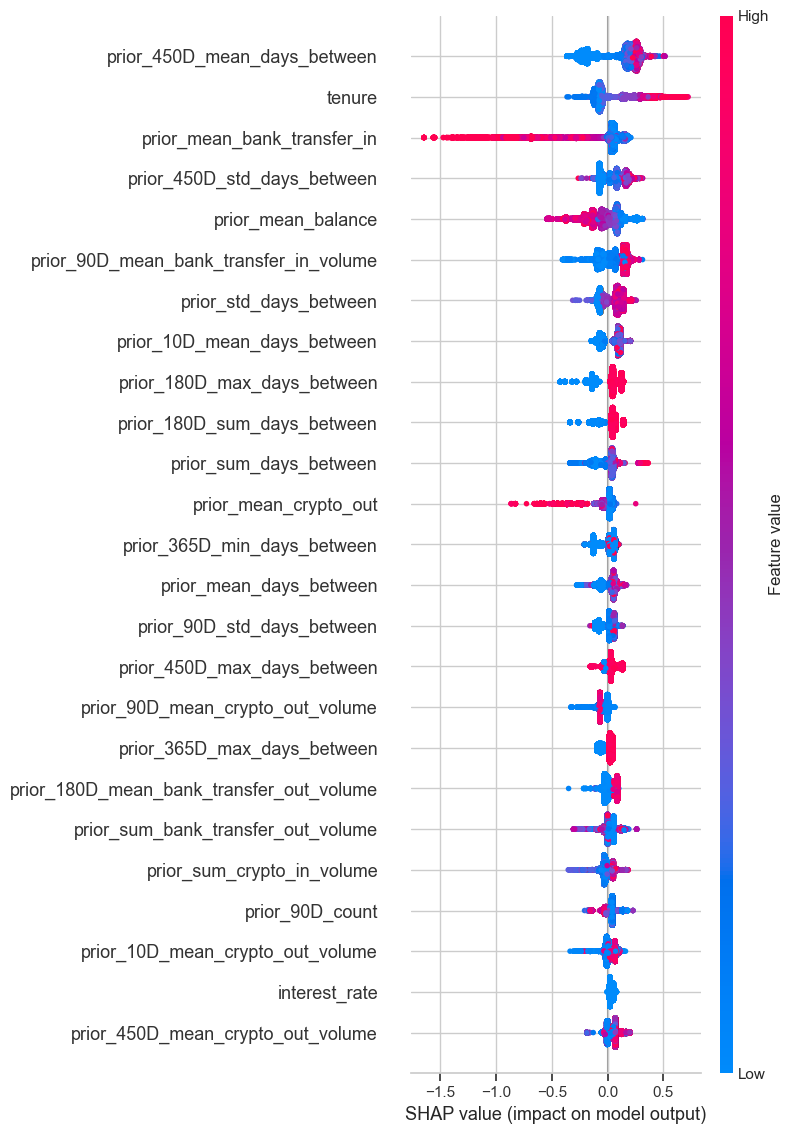

In [15]:
# SHAP Values
shap_explainer = shap.Explainer(model)
shap_values = shap_explainer(X_validation)
shap.summary_plot(shap_values, X_validation, plot_type='dot', max_display=25)

In [16]:
X_train.dtypes

interest_rate                        float16
country                             category
customer_age                         float16
broad_job_category                  category
tenure                                 int16
                                      ...   
prior_450D_sum_crypto_out_volume     float16
prior_450D_bank_balance              float32
prior_450D_mean_balance              float32
this_week_bank_volume                float32
this_week_crypto_volume              float16
Length: 152, dtype: object

### Feature Selection with Boruta

In [17]:
# untuned, this is just a set of "reasonable defaults" to get better feature selection
params = {
    'random_strength': 1,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    #'cat_features': cat_features,
    'verbose': False 
}

model = CatBoostClassifier(**params) 

feat_selector = arfsgroot.Leshy(
    model, n_estimators=150, verbose=1, max_iter=10, random_state=55, importance="fastshap",
)

feat_selector.fit(X_train.drop(cat_features, axis=1), y_train)

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
Leshy iteration:  90%|█████████ | 9/10 [02:42<00:18, 18.00s/it]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	37
Tentative: 	47
Rejected: 	66
All relevant predictors selected in 00:02:42.17



The Leshy or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


Leshy(estimator=<catboost.core.CatBoostClassifier object at 0x2b4c6cf10>,
      importance='fastshap', max_iter=10, n_estimators=150,
      random_state=RandomState(MT19937) at 0x104CDEC40, verbose=1)

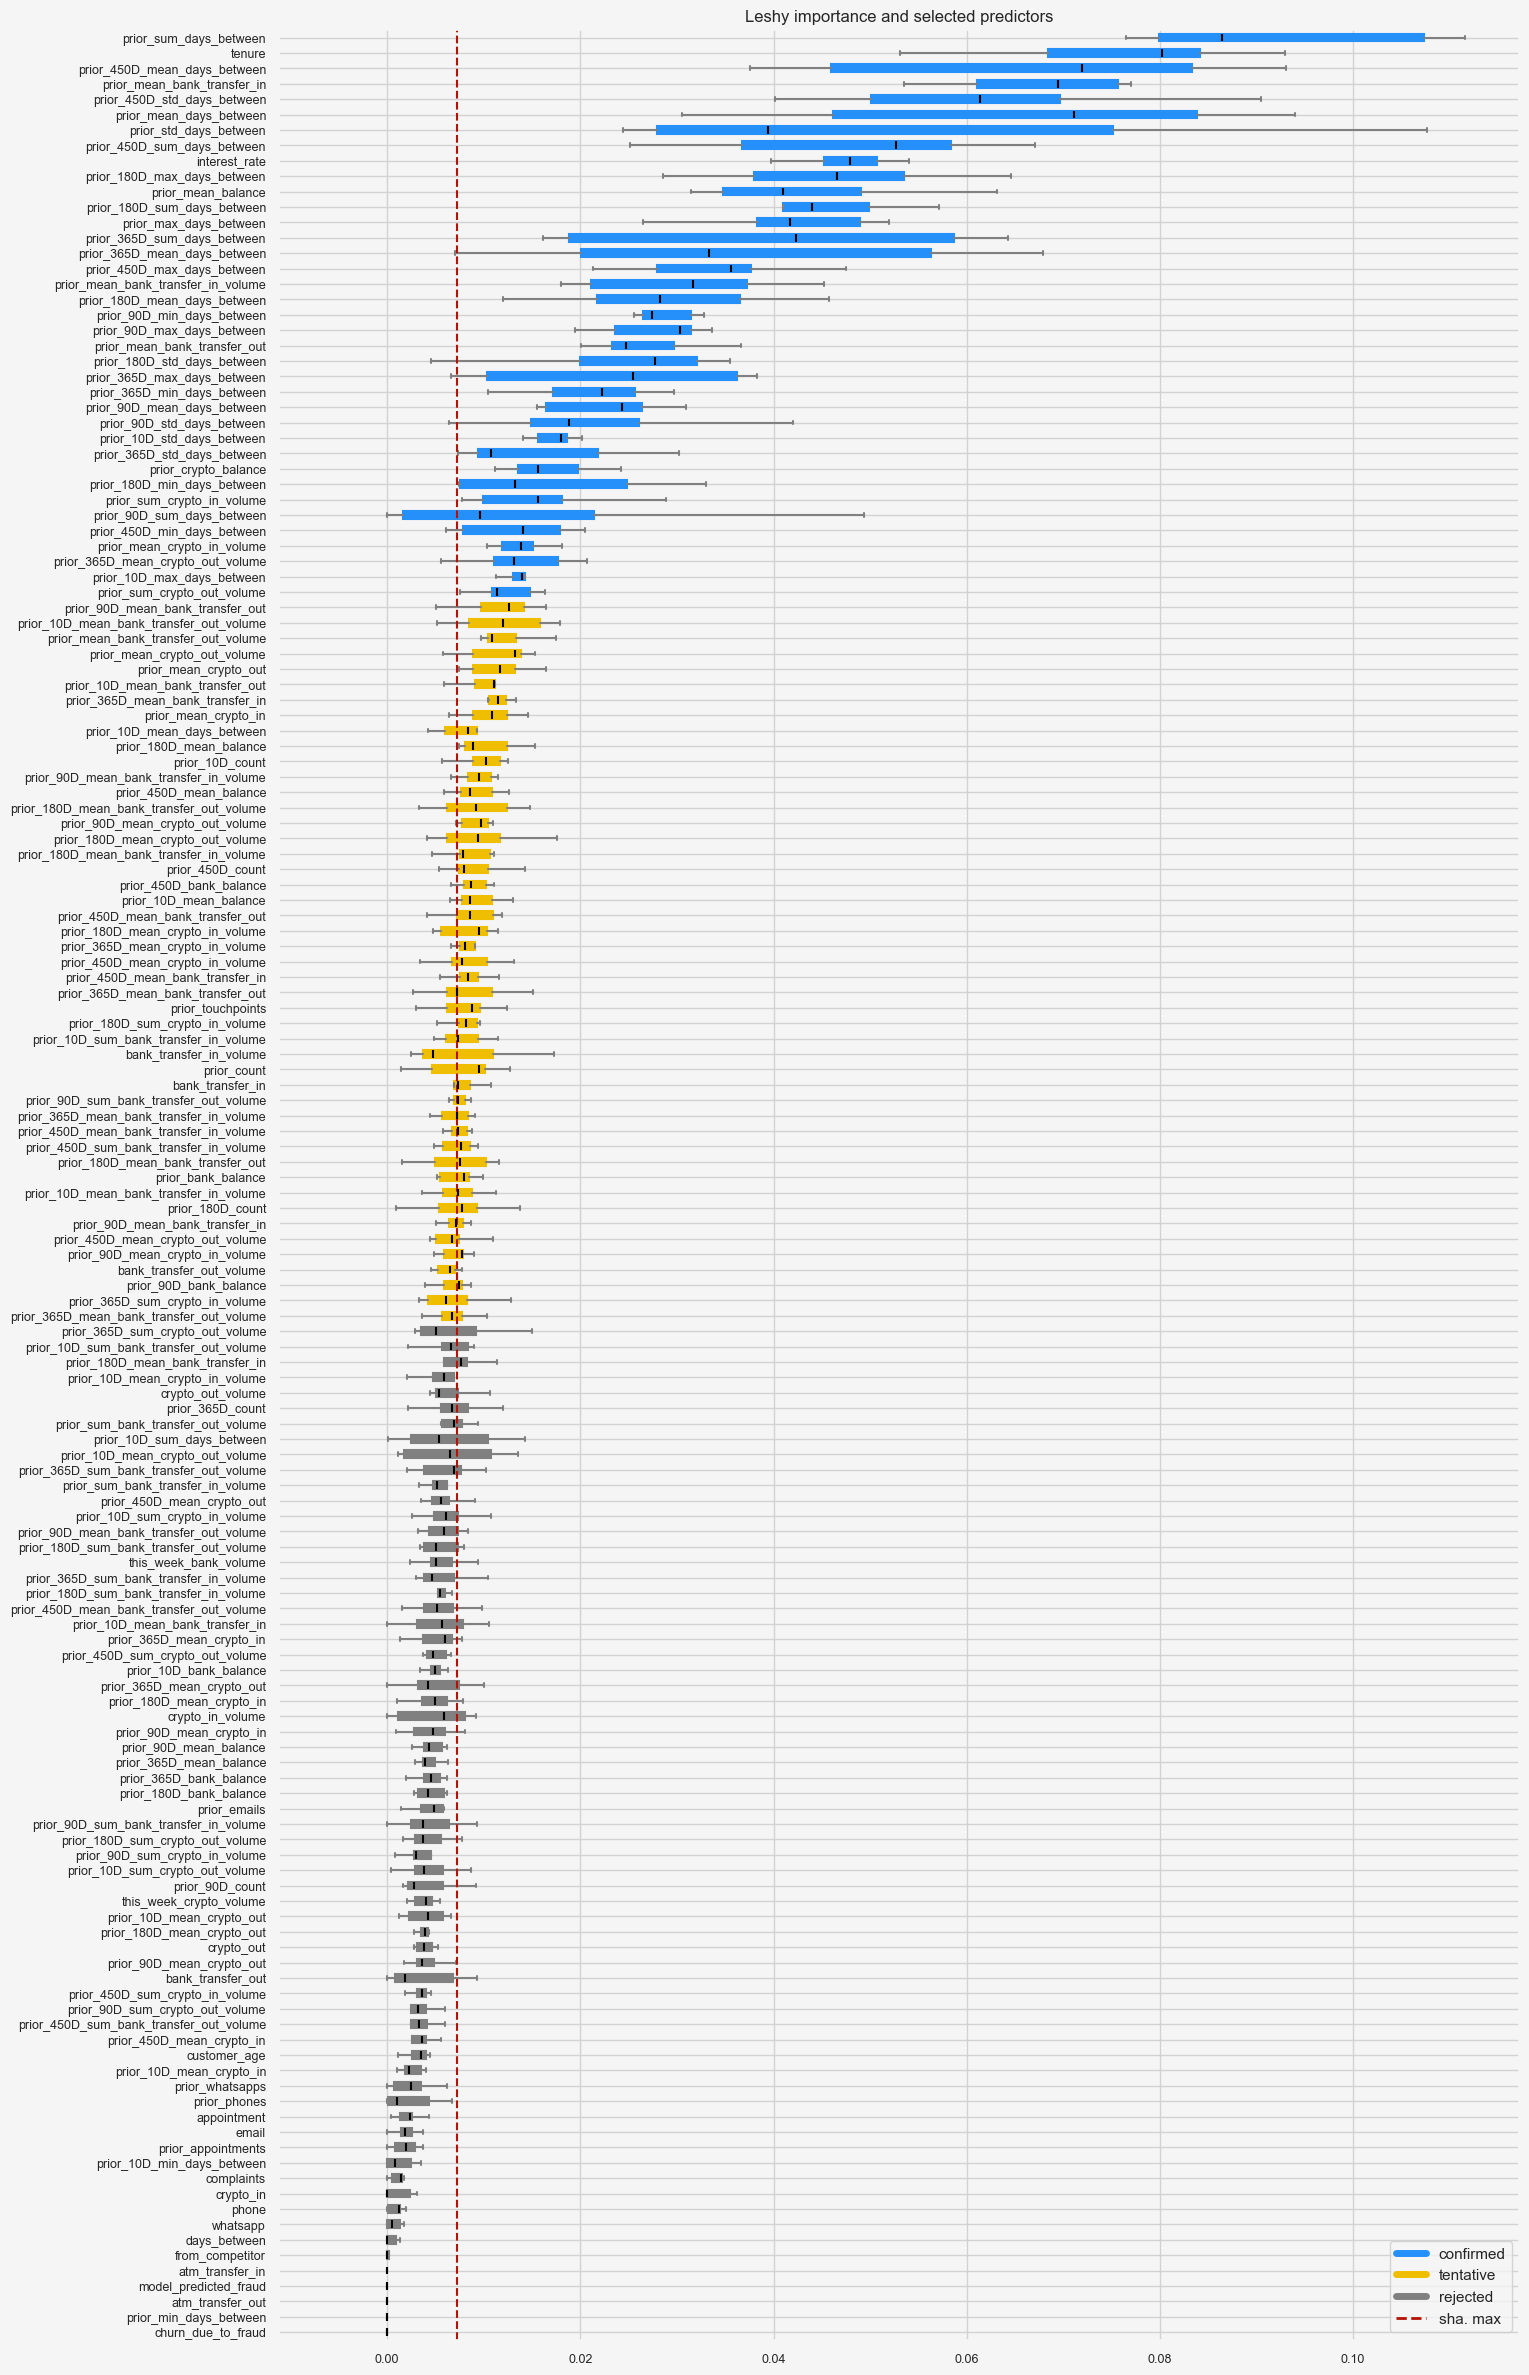

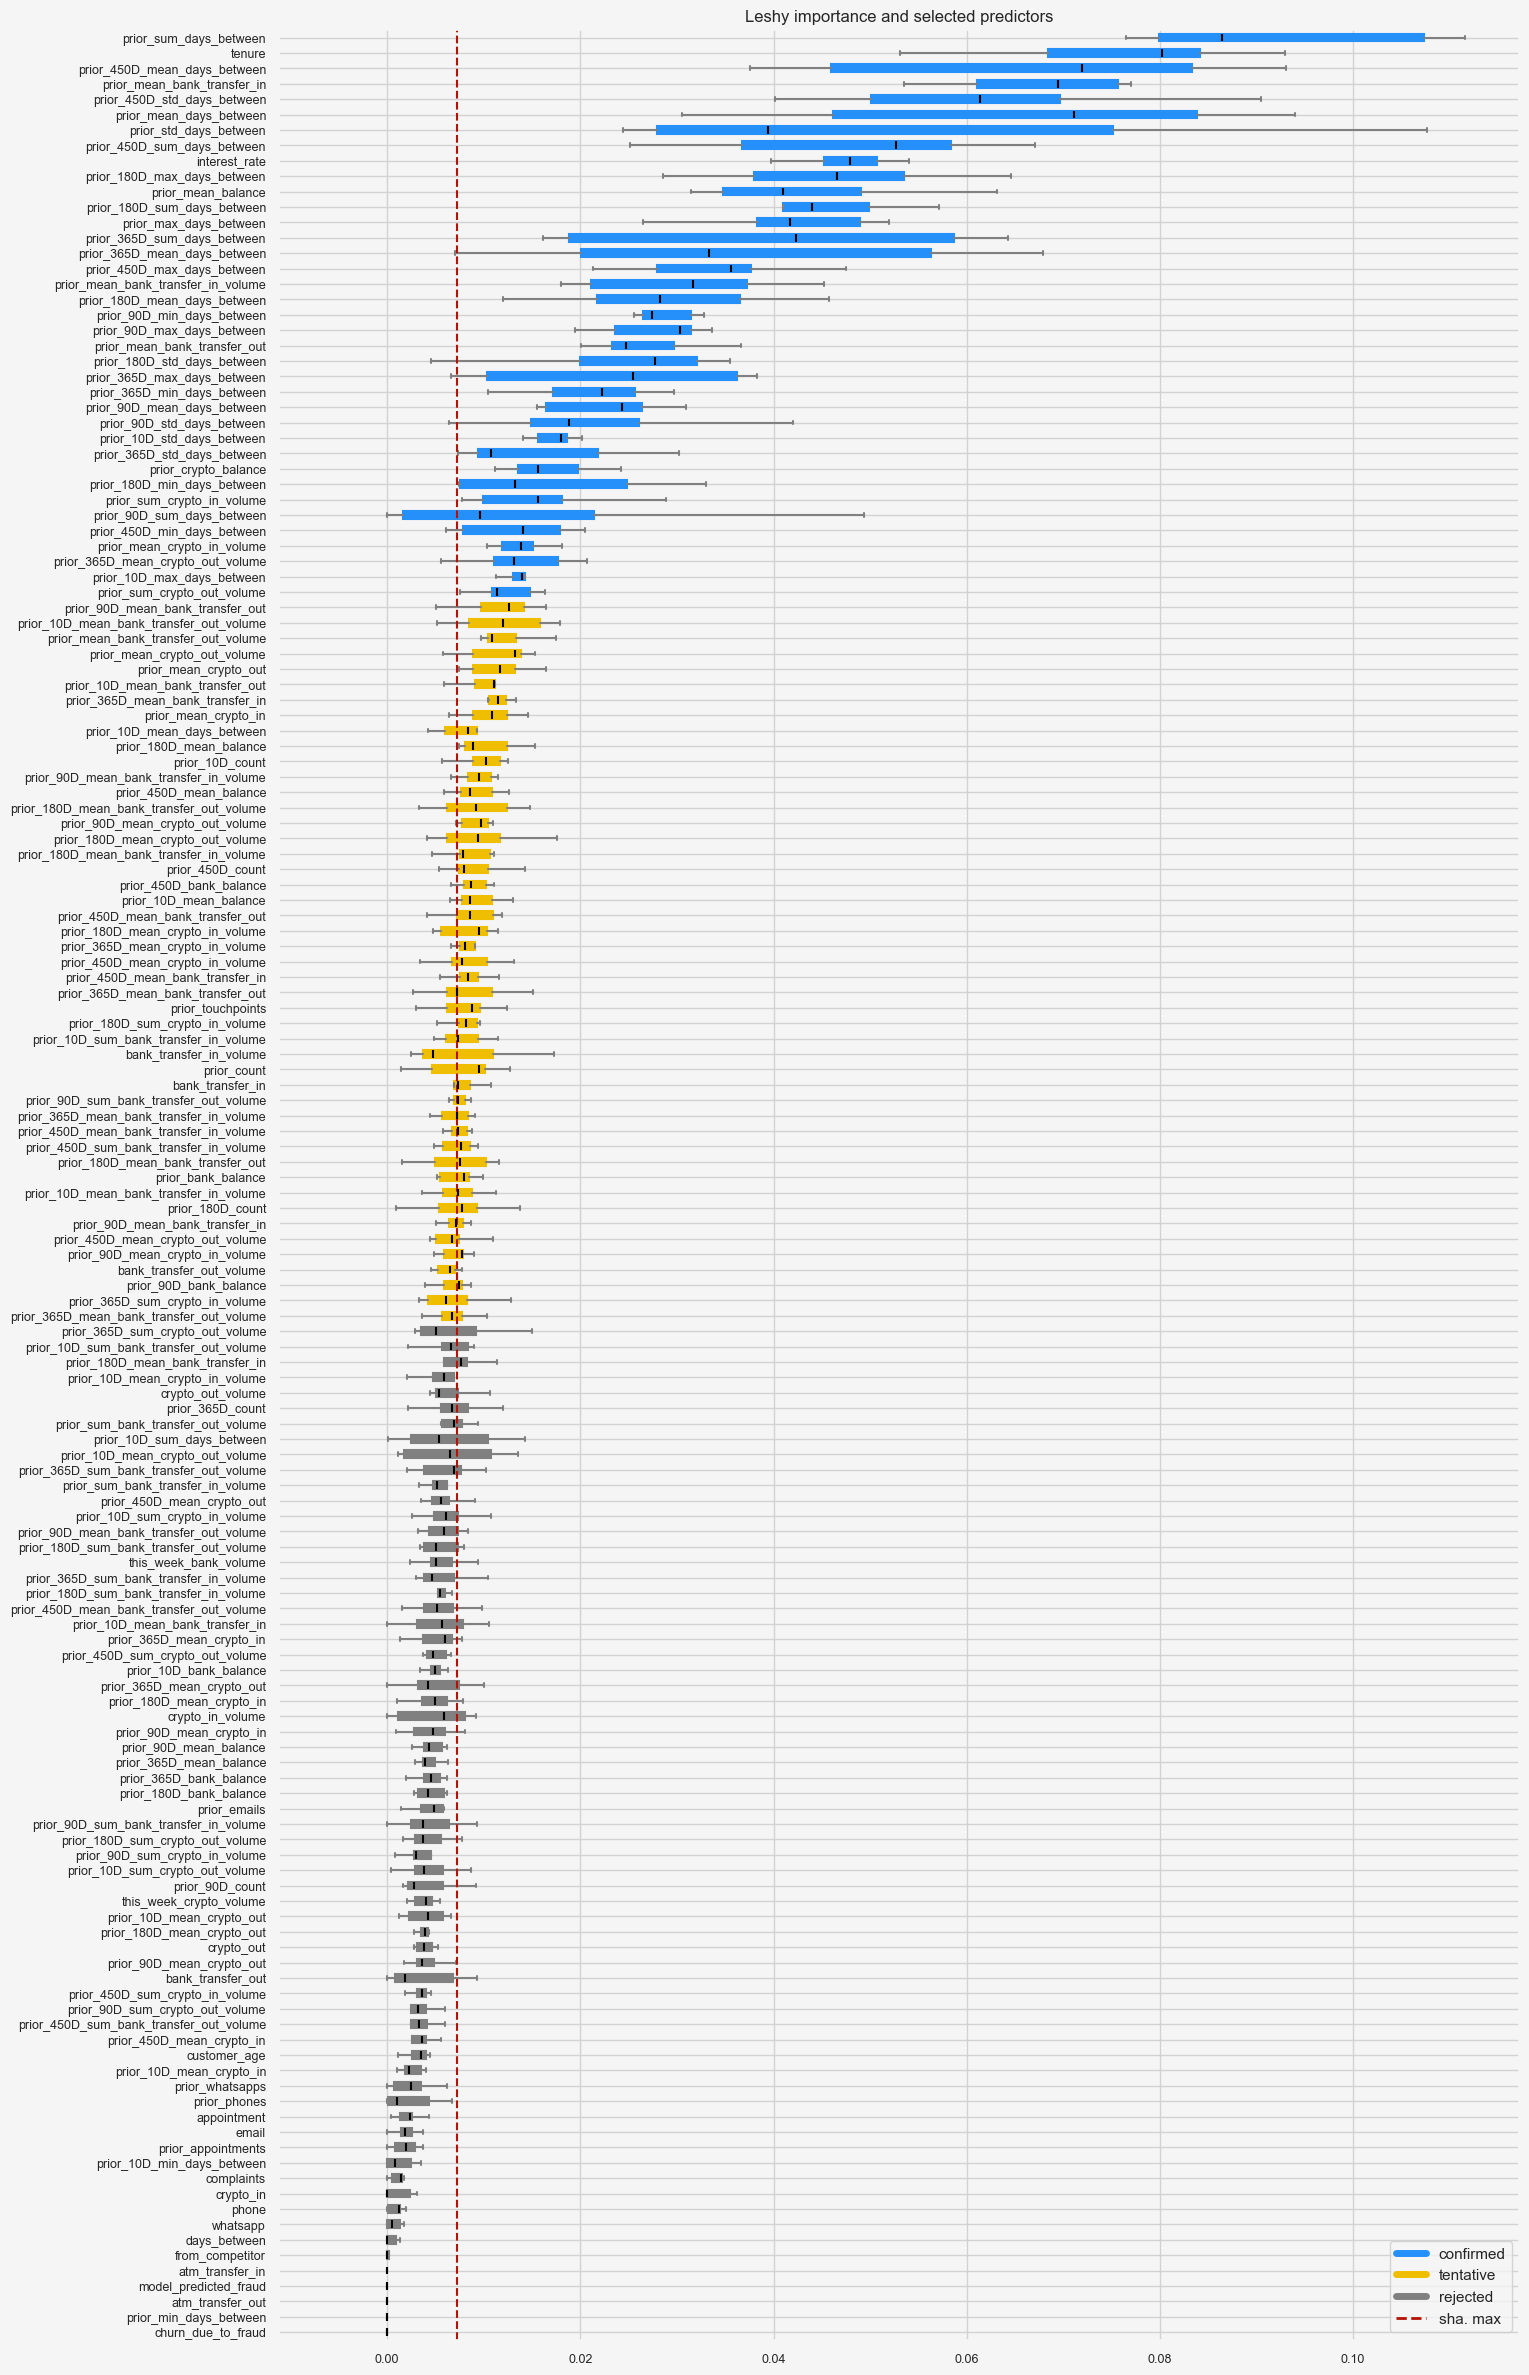

In [18]:
feat_selector.plot_importance()

In [19]:
feat_selector.get_feature_names_out()

The Leshy or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


array(['interest_rate', 'tenure', 'prior_crypto_balance',
       'prior_mean_balance', 'prior_sum_days_between',
       'prior_std_days_between', 'prior_mean_days_between',
       'prior_max_days_between', 'prior_mean_bank_transfer_in',
       'prior_mean_bank_transfer_out', 'prior_mean_crypto_out',
       'prior_mean_bank_transfer_in_volume',
       'prior_mean_crypto_in_volume', 'prior_sum_crypto_in_volume',
       'prior_sum_crypto_out_volume', 'prior_10D_std_days_between',
       'prior_10D_mean_bank_transfer_out', 'prior_90D_mean_days_between',
       'prior_90D_std_days_between', 'prior_90D_min_days_between',
       'prior_90D_mean_bank_transfer_out',
       'prior_90D_mean_bank_transfer_in_volume',
       'prior_90D_mean_crypto_out_volume', 'prior_180D_sum_days_between',
       'prior_180D_mean_days_between', 'prior_180D_max_days_between',
       'prior_180D_min_days_between', 'prior_180D_mean_balance',
       'prior_365D_sum_days_between', 'prior_365D_mean_days_between',
      

In [20]:
selected_features = feat_selector.get_feature_names_out().tolist() + ['country', 'broad_job_category']


# Save the selected features
with open('./week_1/model/selected_features_list.json', 'w') as f:
    json.dump(selected_features, f)

In [21]:
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")

The selected features: ['interest_rate' 'tenure' 'prior_crypto_balance' 'prior_mean_balance'
 'prior_sum_days_between' 'prior_std_days_between'
 'prior_mean_days_between' 'prior_max_days_between'
 'prior_mean_bank_transfer_in' 'prior_mean_bank_transfer_out'
 'prior_mean_crypto_out' 'prior_mean_bank_transfer_in_volume'
 'prior_mean_crypto_in_volume' 'prior_sum_crypto_in_volume'
 'prior_sum_crypto_out_volume' 'prior_10D_std_days_between'
 'prior_10D_mean_bank_transfer_out' 'prior_90D_mean_days_between'
 'prior_90D_std_days_between' 'prior_90D_min_days_between'
 'prior_90D_mean_bank_transfer_out'
 'prior_90D_mean_bank_transfer_in_volume'
 'prior_90D_mean_crypto_out_volume' 'prior_180D_sum_days_between'
 'prior_180D_mean_days_between' 'prior_180D_max_days_between'
 'prior_180D_min_days_between' 'prior_180D_mean_balance'
 'prior_365D_sum_days_between' 'prior_365D_mean_days_between'
 'prior_365D_std_days_between' 'prior_365D_min_days_between'
 'prior_365D_mean_crypto_in_volume' 'prior_450D_s

### Train a Vanilla CatBoost Model with Selected Features

In [34]:
if selected_features == None:
    selected_features = ["interest_rate", "tenure", "prior_crypto_balance", "prior_mean_balance", "prior_sum_days_between", "prior_std_days_between", "prior_mean_days_between", "prior_max_days_between", "prior_mean_bank_transfer_in", "prior_mean_bank_transfer_out", "prior_mean_crypto_out", "prior_mean_bank_transfer_in_volume", "prior_mean_crypto_in_volume", "prior_sum_crypto_in_volume", "prior_sum_crypto_out_volume", "prior_10D_std_days_between", "prior_10D_mean_bank_transfer_out", "prior_10D_mean_balance", "prior_90D_mean_days_between", "prior_90D_std_days_between", "prior_90D_min_days_between", "prior_90D_mean_bank_transfer_out", "prior_180D_sum_days_between", "prior_180D_mean_days_between", "prior_180D_std_days_between", "prior_180D_max_days_between", "prior_180D_min_days_between", "prior_365D_sum_days_between", "prior_365D_mean_days_between", "prior_365D_min_days_between", "prior_450D_sum_days_between", "prior_450D_mean_days_between", "prior_450D_std_days_between", "prior_450D_max_days_between", "country", "broad_job_category"]

cat_features = ['country', 'broad_job_category']

model_selected = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='PRAUC:use_weights=false', cat_features=cat_features, verbose=True, random_seed=255)
model_selected.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation), early_stopping_rounds=100)

y_pred_selected = model_selected.predict_proba(X_validation[selected_features])[:, 1]

Learning rate set to 0.13035
0:	learn: 0.0148090	test: 0.0268104	best: 0.0268104 (0)	total: 49.5ms	remaining: 49.5s
1:	learn: 0.0156062	test: 0.0266898	best: 0.0268104 (0)	total: 101ms	remaining: 50.3s
2:	learn: 0.0170137	test: 0.0281518	best: 0.0281518 (2)	total: 154ms	remaining: 51.2s
3:	learn: 0.0185938	test: 0.0282205	best: 0.0282205 (3)	total: 205ms	remaining: 50.9s
4:	learn: 0.0180156	test: 0.0284235	best: 0.0284235 (4)	total: 279ms	remaining: 55.6s
5:	learn: 0.0187744	test: 0.0303256	best: 0.0303256 (5)	total: 343ms	remaining: 56.8s
6:	learn: 0.0192152	test: 0.0292996	best: 0.0303256 (5)	total: 413ms	remaining: 58.5s
7:	learn: 0.0190771	test: 0.0291118	best: 0.0303256 (5)	total: 480ms	remaining: 59.5s
8:	learn: 0.0190584	test: 0.0290059	best: 0.0303256 (5)	total: 580ms	remaining: 1m 3s
9:	learn: 0.0196509	test: 0.0284863	best: 0.0303256 (5)	total: 645ms	remaining: 1m 3s
10:	learn: 0.0196304	test: 0.0281800	best: 0.0303256 (5)	total: 710ms	remaining: 1m 3s
11:	learn: 0.0202847	te

In [35]:
# Model metrics report
clf_metric_report(y_pred_selected, y_validation)

Evaluating the model...
ROC AUC: 0.6878285744573747
Brier Score: 0.26953665909399593
Average Precision: 0.03045112383369109
Log Loss: 0.7281588620056951


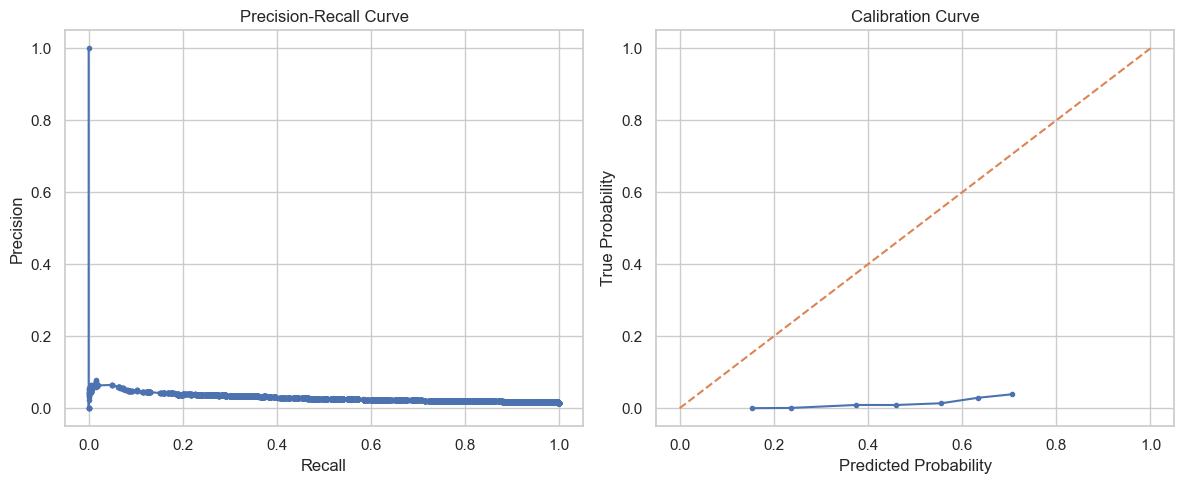

In [36]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_selected, y_validation)

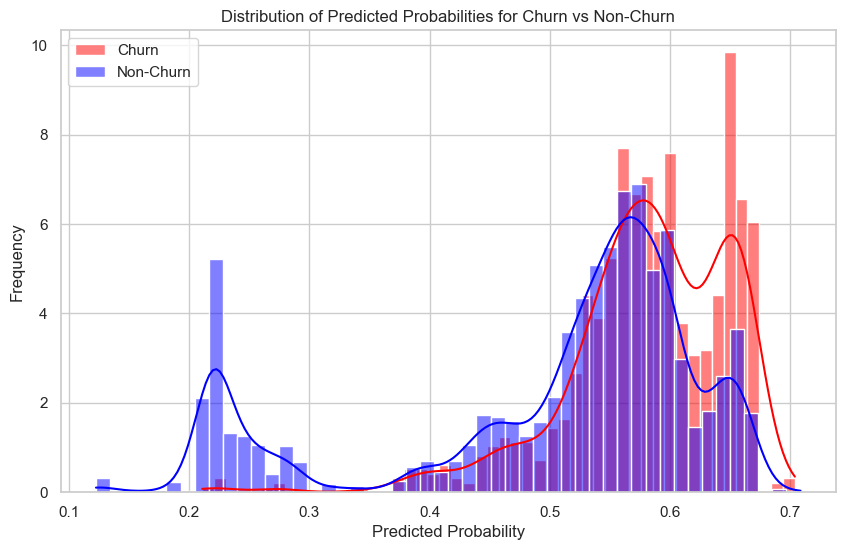

In [37]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_selected, y_validation)

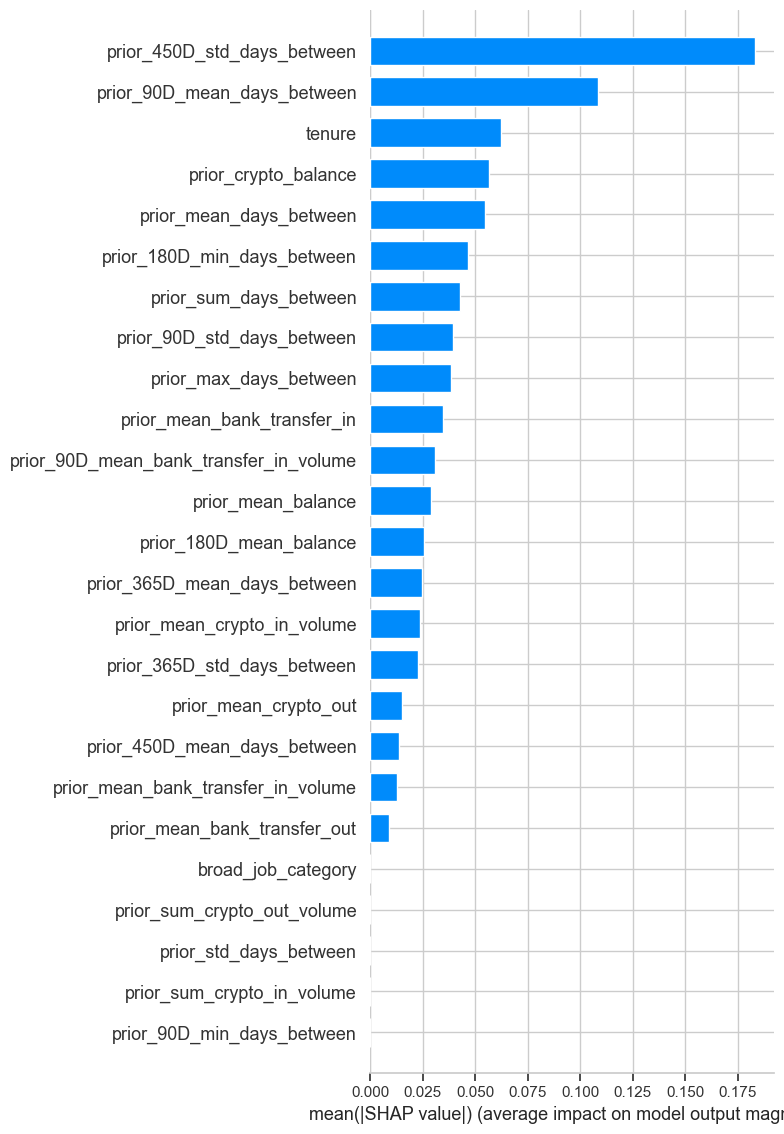

In [38]:
# SHAP Values
shape_explainer = shap.Explainer(model_selected)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

In [39]:
X_validation[selected_features]

,interest_rate,tenure,prior_crypto_balance,prior_mean_balance,prior_sum_days_between,prior_std_days_between,prior_mean_days_between,prior_max_days_between,prior_mean_bank_transfer_in,prior_mean_bank_transfer_out,...,prior_365D_mean_days_between,prior_365D_std_days_between,prior_365D_min_days_between,prior_365D_mean_crypto_in_volume,prior_450D_sum_days_between,prior_450D_mean_days_between,prior_450D_std_days_between,prior_450D_max_days_between,country,broad_job_category
4774534,0.0,1169,1346.0000,204.125,1169.0,110.3750,35.43750,392.0,413.000,315.750000,...,186.5000,186.5000,2.0,59.00000,748.0,187.00000,187.00000,374.0,Sweden,Other
2243970,0.0,397,2898.0000,1159.000,397.0,84.0625,19.84375,377.0,4204.000,3580.000000,...,28.0000,28.0000,1.0,432.25000,397.0,19.84375,19.84375,377.0,Hungary,Unemployed
2454377,0.0,758,2836.0000,968.000,758.0,105.5625,32.96875,369.0,3102.000,2664.000000,...,62.0000,62.0000,1.0,56.65625,754.0,41.87500,41.87500,369.0,Ireland,Other
2453728,0.0,1900,3842.0000,1010.000,1900.0,115.2500,40.43750,380.0,1890.000,1461.000000,...,380.0000,380.0000,380.0,692.50000,762.0,84.68750,84.68750,380.0,Ireland,Healthcare & Medicine
3512145,0.0,749,145.3750,650.500,749.0,215.7500,187.25000,380.0,480.000,10.500000,...,380.0000,380.0000,380.0,52.81250,749.0,249.62500,249.62500,380.0,Norway,Engineering
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880412,0.0,1145,773.0000,691.500,1145.0,128.1250,49.78125,378.0,485.000,2.130859,...,125.3125,125.3125,1.0,60.84375,745.0,186.25000,186.25000,373.0,Latvia,Other
3506429,0.0,388,97.3125,669.000,388.0,223.1250,129.37500,387.0,228.625,36.656250,...,387.0000,387.0000,387.0,49.75000,388.0,129.37500,129.37500,387.0,Norway,Nonprofit & Charity
2233384,0.0,759,571.0000,731.000,759.0,194.8750,126.50000,383.0,2116.000,1821.000000,...,187.0000,187.0000,1.0,466.75000,757.0,252.37500,252.37500,383.0,Hungary,Science & Research
133315,0.0,2345,2646.0000,788.500,2344.0,104.4375,32.12500,406.0,504.500,177.125000,...,187.5000,187.5000,1.0,155.50000,748.0,187.00000,187.00000,374.0,Austria,Finance & Accounting


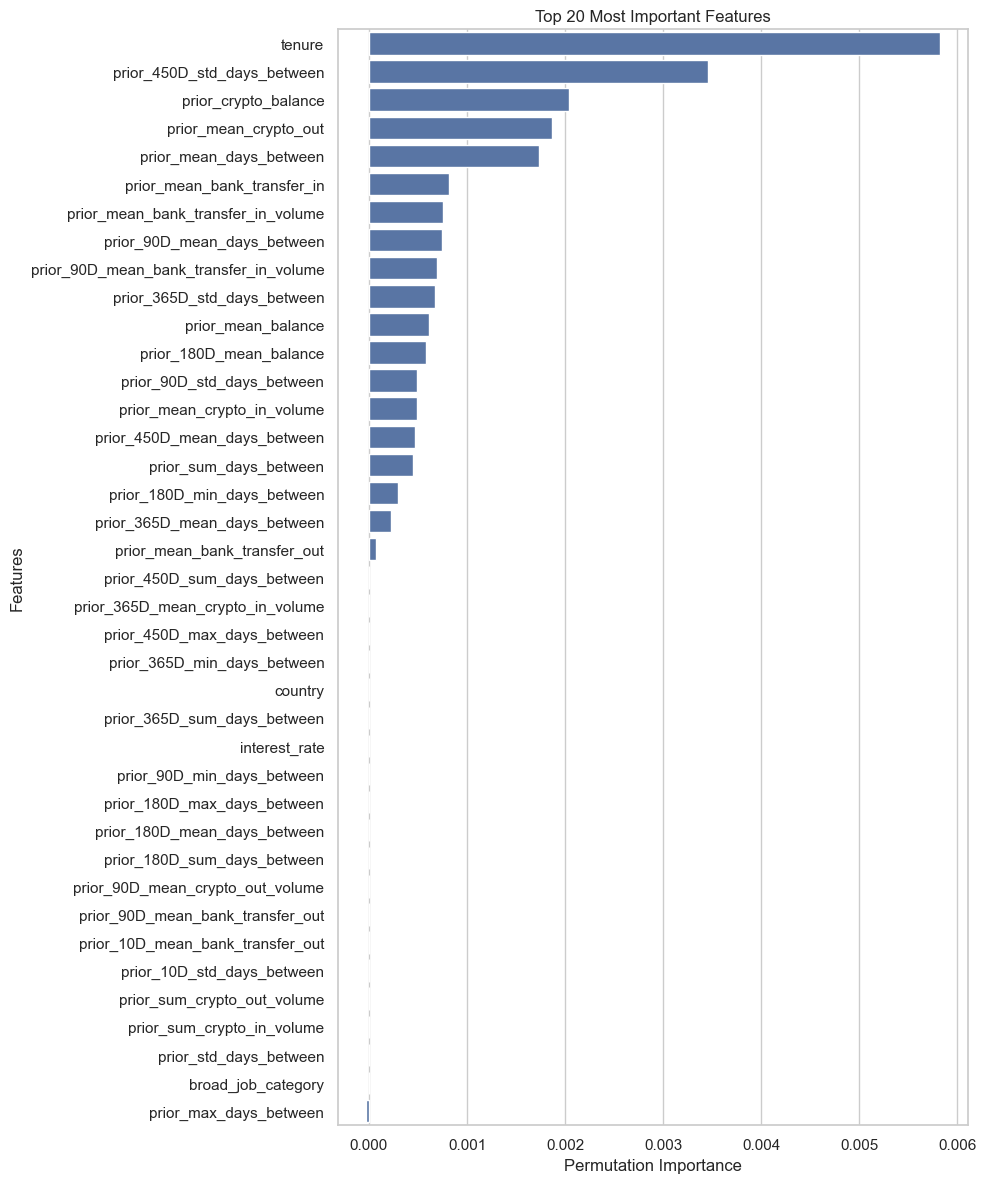

In [40]:
# Permutation importance
# feature_importance = compute_and_plot_permutation_importance(model, X_validation[selected_features], y_validation)

### Perform Optuna Hyperparameter Tuning

In [43]:
# https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm
# params = {'depth': [2, 6, 10],
#           'learning_rate' : [0.01, 0.05, 0.08, 0.1,0.5],
#          'l2_leaf_reg': [1, 3, 5, 7, 9],
#          'iterations': [50, 100, 150, 300, 500, 750, 1000]}


params = {
    'random_strength': 1,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'eval_metric': 'PRAUC:use_weights=false',
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    'verbose': False 
}


def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [50, 100, 150, 300, 500, 750, 1000]),
        'max_depth': trial.suggest_categorical('depth', [4, 8, 10, 14]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.5, 0.8, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.8, 1.0]),
        'eval_metric': 'PRAUC:use_weights=false',
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        #'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e-1),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced', None]),
        'cat_features': cat_features,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation), early_stopping_rounds=100)
    y_pred = model.predict_proba(X_validation[selected_features])[:, 1]
    return average_precision_score(y_validation, y_pred)

study = optuna.create_study(direction='maximize')

# Optimize for 1 hour 
#study.optimize(objective, timeout=3600)
study.optimize(objective, timeout=60*10)

best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-01-05 17:53:58,514] A new study created in memory with name: no-name-ae1e1198-bf68-49e8-b7ec-55bd75dc01c2
[I 2025-01-05 17:54:11,767] Trial 0 finished with value: 0.032039676630201616 and parameters: {'iterations': 750, 'depth': 8, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.033430326833862184, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.032039676630201616.
[I 2025-01-05 17:54:19,343] Trial 1 finished with value: 0.029783363012008957 and parameters: {'iterations': 100, 'depth': 8, 'colsample_bylevel': 1.0, 'subsample': 0.5, 'learning_rate': 0.00016244656555910496, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.032039676630201616.
[I 2025-01-05 17:54:30,395] Trial 2 finished with value: 0.02955214002862159 and parameters: {'iterations': 1000, 'depth': 8, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.00012801979449586647, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.03203967

Best parameters: {'iterations': 750, 'depth': 8, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.020432250208778428, 'auto_class_weights': 'SqrtBalanced'}


In [48]:
# Save the best parameters to a JSON file
best_params_path = './week_1/model/best_params.json'
with open(best_params_path, 'w') as f:
    json.dump(best_params, f, indent=4)

### Retrain the Model with the Best Parameters

In [57]:
if best_params == None: 
    best_params = {'iterations': 750, 'depth': 8, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.020432250208778428, 'auto_class_weights': 'SqrtBalanced'}


#model_best = CatBoostClassifier(**best_params, eval_metric='PRAUC:use_weights=false', cat_features=cat_features, early_stopping_rounds=100, random_state=55)
model_best = CatBoostClassifier(**best_params, eval_metric='PRAUC:use_weights=false', cat_features=cat_features, early_stopping_rounds=100, random_state=55)
model_best.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation))

y_pred_best = model_best.predict_proba(X_validation[selected_features])[:, 1]

# Model metrics report
clf_metric_report(y_pred_best, y_validation)

0:	learn: 0.0181754	test: 0.0215478	best: 0.0215478 (0)	total: 58.3ms	remaining: 43.7s
1:	learn: 0.0180885	test: 0.0275011	best: 0.0275011 (1)	total: 124ms	remaining: 46.2s
2:	learn: 0.0172009	test: 0.0279230	best: 0.0279230 (2)	total: 185ms	remaining: 46.1s
3:	learn: 0.0177248	test: 0.0288576	best: 0.0288576 (3)	total: 248ms	remaining: 46.3s
4:	learn: 0.0183508	test: 0.0281000	best: 0.0288576 (3)	total: 313ms	remaining: 46.6s
5:	learn: 0.0184003	test: 0.0286278	best: 0.0288576 (3)	total: 384ms	remaining: 47.6s
6:	learn: 0.0188205	test: 0.0284136	best: 0.0288576 (3)	total: 485ms	remaining: 51.5s
7:	learn: 0.0195209	test: 0.0280786	best: 0.0288576 (3)	total: 569ms	remaining: 52.8s
8:	learn: 0.0203789	test: 0.0283592	best: 0.0288576 (3)	total: 645ms	remaining: 53.1s
9:	learn: 0.0203872	test: 0.0277482	best: 0.0288576 (3)	total: 723ms	remaining: 53.5s
10:	learn: 0.0203770	test: 0.0281700	best: 0.0288576 (3)	total: 828ms	remaining: 55.6s
11:	learn: 0.0206391	test: 0.0286321	best: 0.0288576

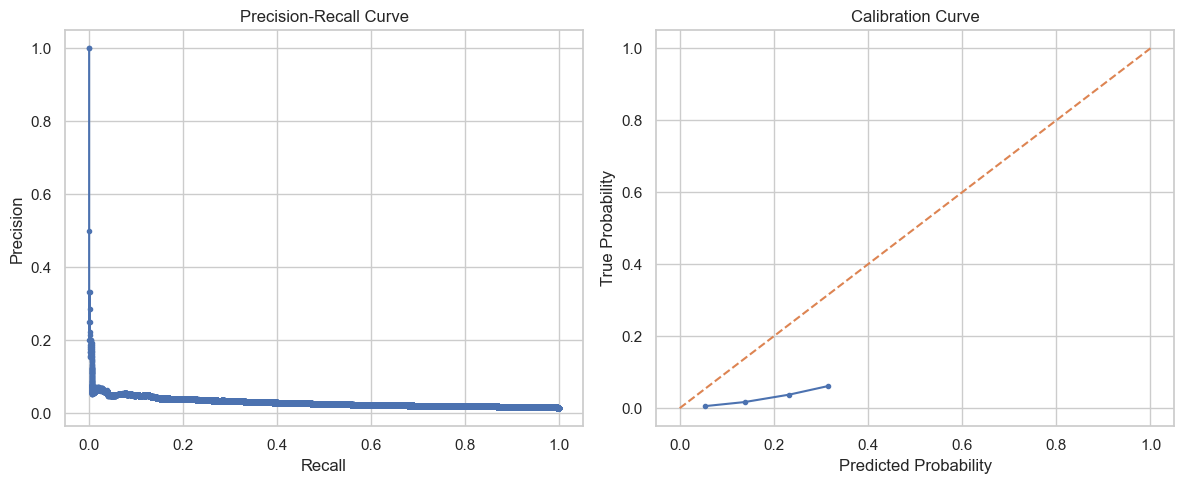

In [58]:
if best_params == None: 
    best_params = {
        'iterations': 300, 'depth': 10, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.0035227238500242664, 'auto_class_weights': 'Balanced'
    }


model_best = CatBoostClassifier(**best_params, eval_metric='PRAUC:use_weights=false', cat_features=cat_features, early_stopping_rounds=100)
model_best.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation))

y_pred_best = model_best.predict_proba(X_validation[selected_features])[:, 1]

# Model metrics report
clf_metric_report(y_pred_best, y_validation)

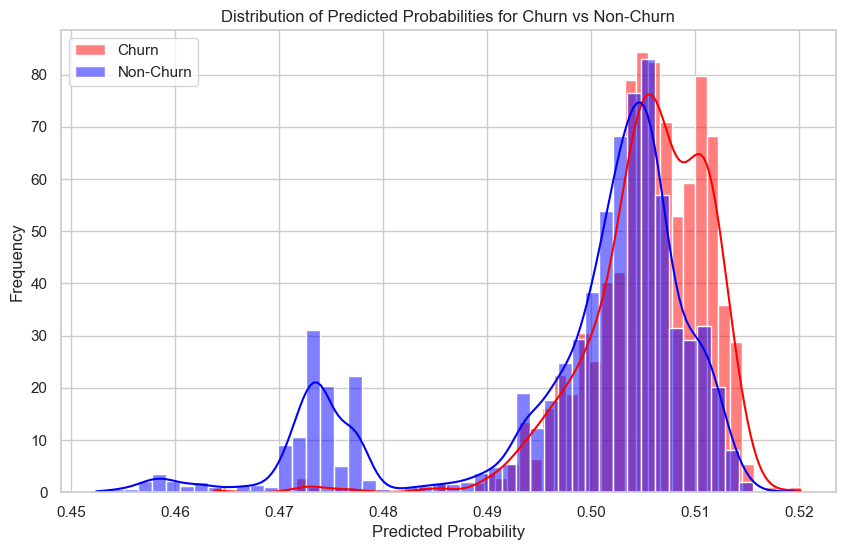

In [88]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_best, y_validation)

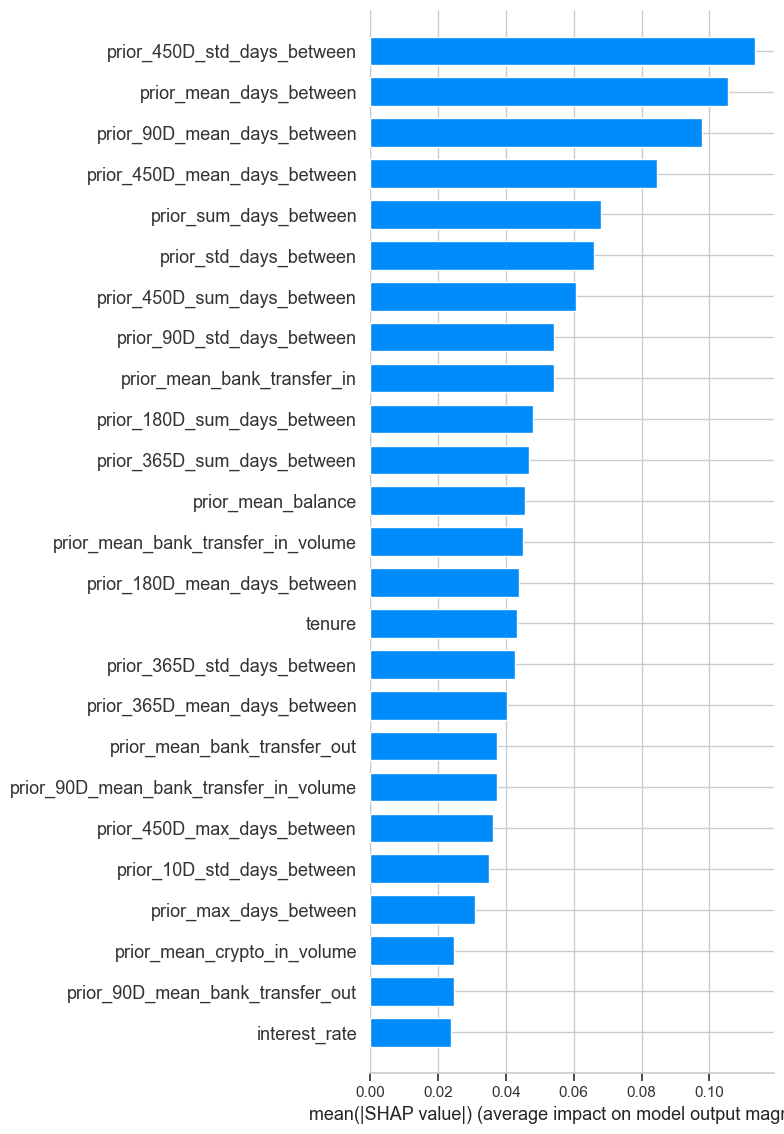

In [ ]:
# SHAP Values
shape_explainer = shap.Explainer(model_best)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation, type='dot')

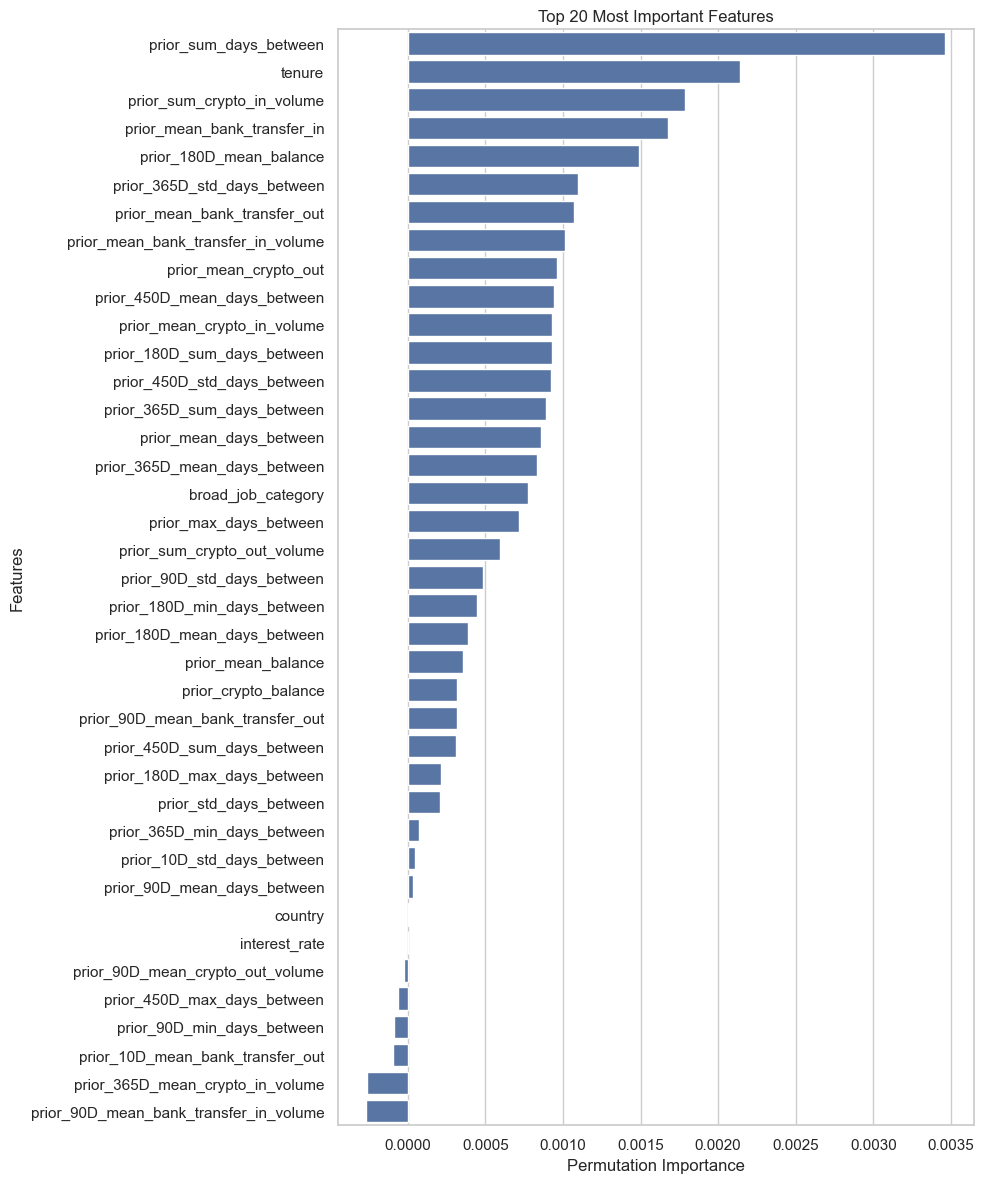

In [60]:
# SHAP Values
shape_explainer = shap.Explainer(model_best)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

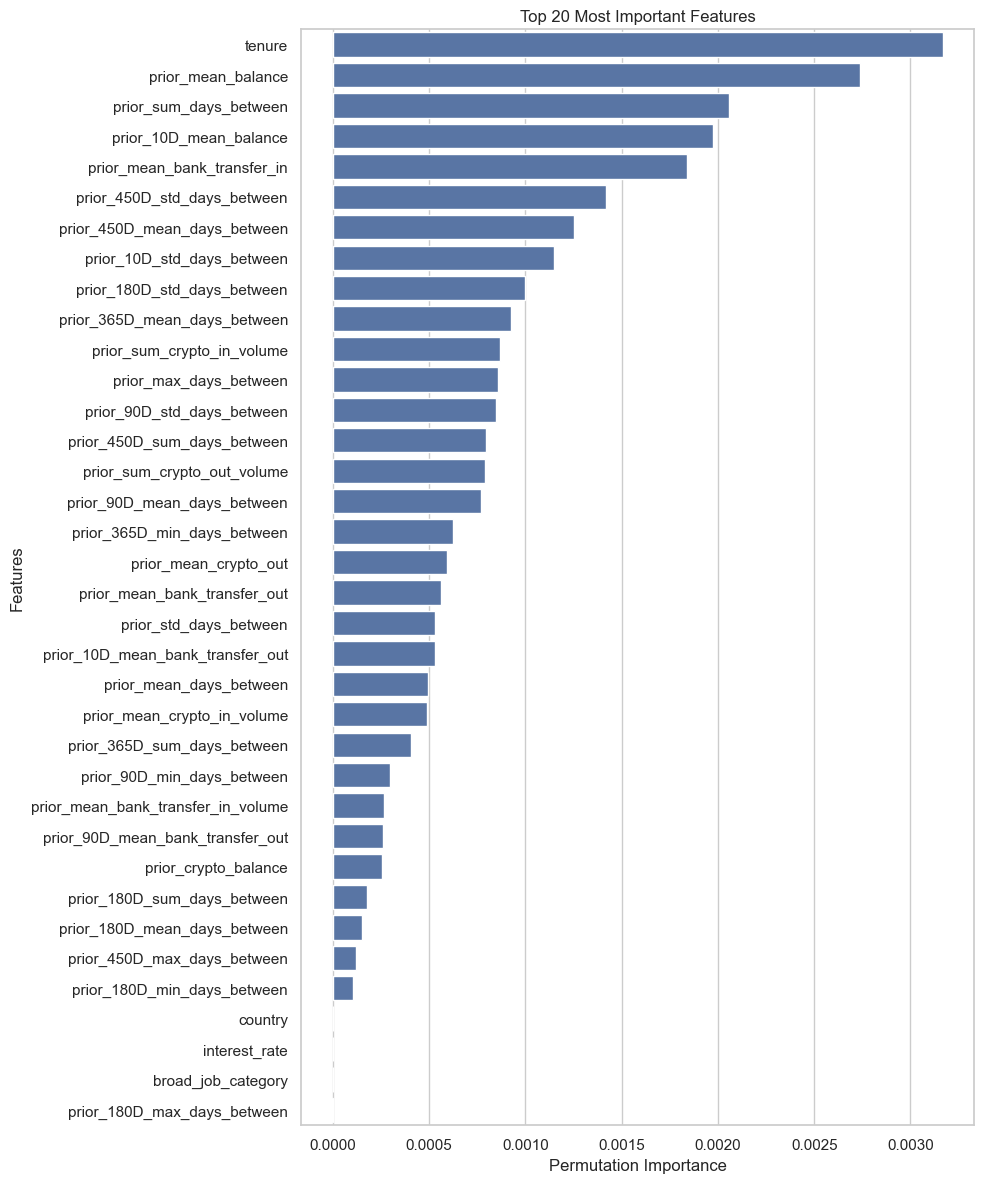

In [86]:
# Permutation importance
feature_importance = compute_and_plot_permutation_importance(model_best, X_validation[selected_features], y_validation, metric='average_precision')

In [ ]:
calibrated_model = CalibratedClassifierCV(model_best, method='sigmoid')
calibrated_model.fit(X_calibration[selected_features], y_calibration)

y_pred_calibrated = calibrated_model.predict_proba(X_validation[selected_features])[:, 1]

In [67]:
clf_metric_report(y_pred_calibrated, y_validation)

Evaluating the model...
ROC AUC: 0.7038301802195817
Brier Score: 0.013635016904919044
Average Precision: 0.029863333562870294
Log Loss: 0.0692207945406831


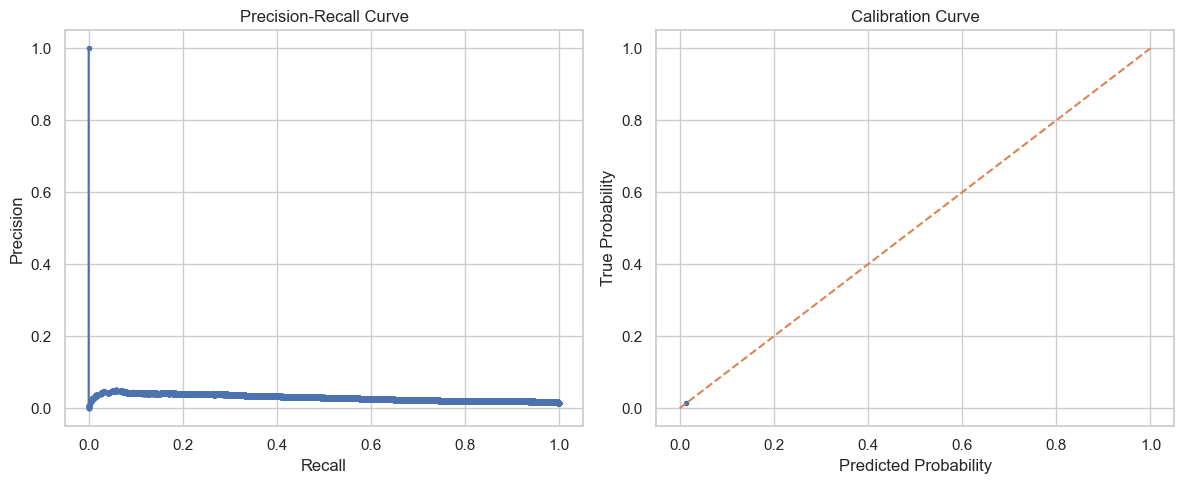

In [68]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_calibrated, y_validation)

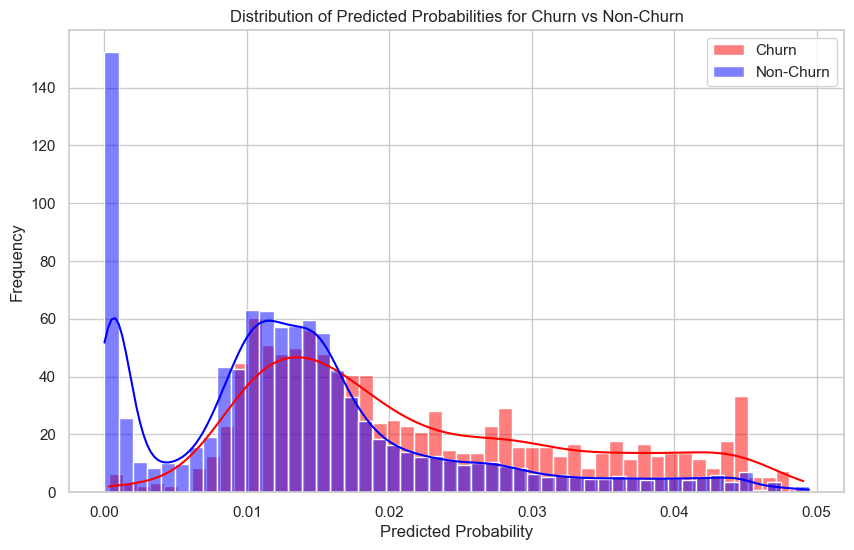

In [69]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_calibrated, y_validation)

In [78]:
# Save the calibrated model
model_path = './week_1/model/calibrated_model.joblib'
joblib.dump(calibrated_model, model_path)

print(f"Calibrated model saved to: {model_path}")

Calibrated model saved to: ./week_1/model/calibrated_model.joblib


### Venn Abers Calibration

In [ ]:
# Define Venn-ABERS calibrator
va_model = VennAbersCalibrator(estimator=model_best, inductive=True, cal_size=0.2, random_state=101)



In [71]:
print('Vanilla model')
clf_metric_report(y_pred, y_validation)
print('')

print('Feature selection model')
clf_metric_report(y_pred_selected, y_validation)
print('')

print('Tunned model')
clf_metric_report(y_pred_best, y_validation)
print('')

print('Calibrated model')
clf_metric_report(y_pred_calibrated, y_validation)
print('')

Vanilla model
Evaluating the model...
ROC AUC: 0.6879001588963107
Brier Score: 0.29533911260848816
Average Precision: 0.029629163063940703
Log Loss: 0.7800804375344214

Feature selection model
Evaluating the model...
ROC AUC: 0.6878285744573747
Brier Score: 0.26953665909399593
Average Precision: 0.03045112383369109
Log Loss: 0.7281588620056951

Tunned model
Evaluating the model...
ROC AUC: 0.6836172936303028
Brier Score: 0.025638208379981552
Average Precision: 0.031754292382868025
Log Loss: 0.14478182744340057

Calibrated model
Evaluating the model...
ROC AUC: 0.7038301802195817
Brier Score: 0.013635016904919044
Average Precision: 0.029863333562870294
Log Loss: 0.0692207945406831

